# Relative Receiver Speed
Examining the impact of a receiver's relative speed to defenders on passing success.

## Libraries

In [2]:
import logging
import sys
import warnings

import numpy as np
import pandas as pd
from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Setup

In [3]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
# Pandas display
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

In [7]:
# BigQuery
PROJECT_ID = 'ad-big-data-bowl'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-admin.json'

In [32]:
SQL_BASE = \
"""
SELECT
  *,
  ROUND(rec_pass_x_rel - def_pass_x_rel, 3) AS diff_pass_x_rel,
  ROUND(rec_pass_y - def_pass_y, 3) AS diff_pass_y,
  ROUND(rec_pass_speed - def_pass_speed, 3) AS diff_pass_speed,
  ROUND(GREATEST(rec_pass_direction_rel - def_pass_direction_rel,
                 def_pass_direction_rel - rec_pass_direction_rel), 3) AS diff_pass_direction_rel,
  ROUND(rec_pass_velocity_x_rel - def_pass_velocity_x_rel, 3) AS diff_pass_velocity_x_rel,
  ROUND(rec_pass_velocity_y - def_pass_velocity_y, 3) AS diff_pass_velocity_y,
  ROUND(rec_pass_accel_x_rel - def_pass_accel_x_rel, 3) AS diff_pass_accel_x_rel,
  ROUND(rec_pass_accel_y - def_pass_accel_y, 3) AS diff_pass_accel_y,
  ROUND(rec_arrived_x_rel - def_arrived_x_rel, 3) AS diff_arrived_x_rel,
  ROUND(rec_arrived_y - def_arrived_y, 3) AS diff_arrived_y,
  ROUND(rec_arrived_speed - def_arrived_speed, 3) AS diff_arrived_speed,
  ROUND(GREATEST(rec_arrived_direction_rel - def_arrived_direction_rel,
                 def_arrived_direction_rel - rec_arrived_direction_rel), 3) AS diff_arrived_direction_rel,
  ROUND(rec_arrived_velocity_x_rel - def_arrived_velocity_x_rel, 3) AS diff_arrived_velocity_x_rel,
  ROUND(rec_arrived_velocity_y - def_arrived_velocity_y, 3) AS diff_arrived_velocity_y,
  ROUND(rec_arrived_accel_x_rel - def_arrived_accel_x_rel, 3) AS diff_arrived_accel_x_rel,
  ROUND(rec_arrived_accel_y - def_arrived_accel_y, 3) AS diff_arrived_accel_y
FROM
  (
    SELECT
      t_rec.*,
      t_def.* EXCEPT (game_id, play_id)
    FROM
      (
        SELECT
          game_id,
          play_id,
          nfl_id AS rec_nfl_id,
          display_name AS rec_display_name,
          CAST(jersey_number AS INT64) AS rec_jersey_number,
          ROUND(pass_x_rel, 3) AS rec_pass_x_rel,
          ROUND(pass_y, 3) AS rec_pass_y,
          ROUND(pass_speed, 3) AS rec_pass_speed,
          ROUND(pass_direction_rel, 3) AS rec_pass_direction_rel,
          ROUND(pass_velocity_x_rel, 3) AS rec_pass_velocity_x_rel,
          ROUND(pass_velocity_y, 3) AS rec_pass_velocity_y,
          ROUND(pass_accel_x_rel, 3) AS rec_pass_accel_x_rel,
          ROUND(pass_accel_y, 3) AS rec_pass_accel_y,
          ROUND(arrived_x_rel, 3) AS rec_arrived_x_rel,
          ROUND(arrived_y, 3) AS rec_arrived_y,
          ROUND(arrived_speed, 3) AS rec_arrived_speed,
          ROUND(arrived_direction_rel, 3) AS rec_arrived_direction_rel,
          ROUND(arrived_velocity_x_rel, 3) AS rec_arrived_velocity_x_rel,
          ROUND(arrived_velocity_y, 3) AS rec_arrived_velocity_y,
          ROUND(arrived_accel_x_rel, 3) AS rec_arrived_accel_x_rel,
          ROUND(arrived_accel_y, 3) AS rec_arrived_accel_y,
          time_to_pass,
          pass_complete_flag,
          play_epa,
          play_air_epa,
          play_yac_epa,
          play_comp_air_epa,
          play_comp_yac_epa
        FROM
          `ad-big-data-bowl.workspace.passes_enhanced`
        WHERE
          targeted_receiver_flag = 1
      ) AS t_rec
        INNER JOIN
      (
        SELECT
          game_id,
          play_id,
          nfl_id AS def_nfl_id,
          display_name AS def_display_name,
          CAST(jersey_number AS INT64) AS def_jersey_number,
          ROUND(pass_x_rel, 3) AS def_pass_x_rel,
          ROUND(pass_y, 3) AS def_pass_y,
          ROUND(pass_speed, 3) AS def_pass_speed,
          ROUND(pass_direction_rel, 3) AS def_pass_direction_rel,
          ROUND(pass_velocity_x_rel, 3) AS def_pass_velocity_x_rel,
          ROUND(pass_velocity_y, 3) AS def_pass_velocity_y,
          ROUND(pass_accel_x_rel, 3) AS def_pass_accel_x_rel,
          ROUND(pass_accel_y, 3) AS def_pass_accel_y,
          ROUND(arrived_x_rel, 3) AS def_arrived_x_rel,
          ROUND(arrived_y, 3) AS def_arrived_y,
          ROUND(arrived_speed, 3) AS def_arrived_speed,
          ROUND(arrived_direction_rel, 3) AS def_arrived_direction_rel,
          ROUND(arrived_velocity_x_rel, 3) AS def_arrived_velocity_x_rel,
          ROUND(arrived_velocity_y, 3) AS def_arrived_velocity_y,
          ROUND(arrived_accel_x_rel, 3) AS def_arrived_accel_x_rel,
          ROUND(arrived_accel_y, 3) AS def_arrived_accel_y
        FROM
          `ad-big-data-bowl.workspace.passes_enhanced`
        WHERE
          targeted_defender_flag = 1
      ) AS t_def
        ON (t_rec.game_id = t_def.game_id
          AND t_rec.play_id = t_def.play_id
        )
  )
"""

In [33]:
# sql_base = SQL_BASE.format(**PARAMS)
sql_base = SQL_BASE

df_base = pd.read_gbq(query=sql_base,
                      project_id=PROJECT_ID,
                      dialect='standard',
                      private_key=SERVICE_ACCOUNT_PATH)

df_copy = df_base.copy()

  Elapsed 6.61 s. Waiting...
  Elapsed 8.03 s. Waiting...
  Elapsed 9.28 s. Waiting...
  Elapsed 10.71 s. Waiting...
  Elapsed 11.97 s. Waiting...
  Elapsed 13.21 s. Waiting...
  Elapsed 14.6 s. Waiting...
  Elapsed 16.04 s. Waiting...
Total time taken 20.53 s.
Finished at 2019-01-19 13:47:24.


In [34]:
df_base.head()

game_id  play_id  rec_nfl_id   rec_display_name  rec_jersey_number  \
0  2017090700     2166     2550268  Charcandrick West                 35   
1  2017091000      522     2543763     Wesley Johnson                 76   
2  2017091000     1062     2507428       Mike Tolbert                 35   
3  2017091000     1144     2530763    Patrick DiMarco                 42   
4  2017091000     1227     2555193      Brandon Shell                 72   

   rec_pass_x_rel  rec_pass_y  rec_pass_speed  rec_pass_direction_rel  \
0           0.390      44.360           5.580                 170.290   
1          -3.620      24.400           3.020                 316.630   
2           0.220      27.900           4.100                 113.130   
3          -0.590      20.310           6.700                 165.350   
4          -4.160      27.930           2.930                 247.710   

   rec_pass_velocity_x_rel  rec_pass_velocity_y  rec_pass_accel_x_rel  \
0                   -0.941                5.500                -0.120   
1                    2.074                2.195                 1.119   
2                   -3.770               -1.611                -0.052   
3                   -1.695               -6.482                -0.083   
4                    2.711                1.111                 0.545   

   rec_pass_accel_y  rec_arrived_x_rel  rec_arrived_y  rec_arrived_speed  \
0             0.182              0.880         48.280              5.480   
1             1.558             -5.770         26.640              3.790   
2            -4.845              2.360         25.980              5.190   
3            -0.909              0.800         14.820              6.980   
4             0.793             -5.930         28.320              2.510   

   rec_arrived_direction_rel  rec_arrived_velocity_x_rel  \
0                    161.160                      -1.770   
1                    317.440                       2.563   
2                    127.000                      -4.145   
3                    164.640                      -1.849   
4                    233.660                       2.022   

   rec_arrived_velocity_y  rec_arrived_accel_x_rel  rec_arrived_accel_y  \
0                   5.186                   -1.893               -0.712   
1                   2.792                   -0.063                0.194   
2                  -3.123                   -0.589               -1.219   
3                  -6.731                   -0.523                0.452   
4                   1.487                   -1.320                1.410   

   time_to_pass  pass_complete_flag  play_epa  play_air_epa  play_yac_epa  \
0         2.100                   1    -0.034        -0.251         0.217   
1         2.100                   1    -1.425        -1.729         0.305   
2         2.900                   1     0.925        -0.580         1.505   
3         2.100                   1     0.542        -0.737         1.279   
4         1.500                   0    -0.684        -0.773         0.088   

   play_comp_air_epa  play_comp_yac_epa  def_nfl_id  def_display_name  \
0             -0.251              0.217     2533057  Dont'a Hightower   
1             -1.729              0.305     2506931     Kyle Williams   
2             -0.580              1.505     2552486  Leonard Williams   
3             -0.737              1.279     2535867   Julian Stanford   
4              0.000              0.000     2555252       Shaq Lawson   

   def_jersey_number  def_pass_x_rel  def_pass_y  def_pass_speed  \
0                 54           4.380      41.160           5.610   
1                 95          -3.630      25.270           4.230   
2                 92          -2.390      28.380           1.070   
3                 51           3.380      22.760           4.900   
4                 90          -3.690      29.050           3.720   

   def_pass_direction_rel  def_pass_velocity_x_rel  def_pass_velocity_y  \
0               

## Data preparation

In [35]:
def distance(x_rel, y_rel):
    return np.sqrt(np.square(x_rel) + np.square(y_rel))

df_base['pass_separation'] = distance(df_base['diff_pass_x_rel'], df_base['diff_pass_y'])
df_base['arrived_separation'] = distance(df_base['diff_arrived_x_rel'], df_base['diff_arrived_y'])

In [36]:
# Filters
_complete = df_base['pass_complete_flag'] == 1
_incomplete = df_base['pass_complete_flag'] == 0

## Plotting

In [44]:
key_features = [
    'time_to_pass',
    'arrived_separation',
    'diff_arrived_speed',
    'diff_arrived_direction_rel',
    'diff_arrived_velocity_x_rel',
    'diff_arrived_velocity_y',
    'diff_arrived_accel_x_rel',
    'diff_arrived_accel_y'
]

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


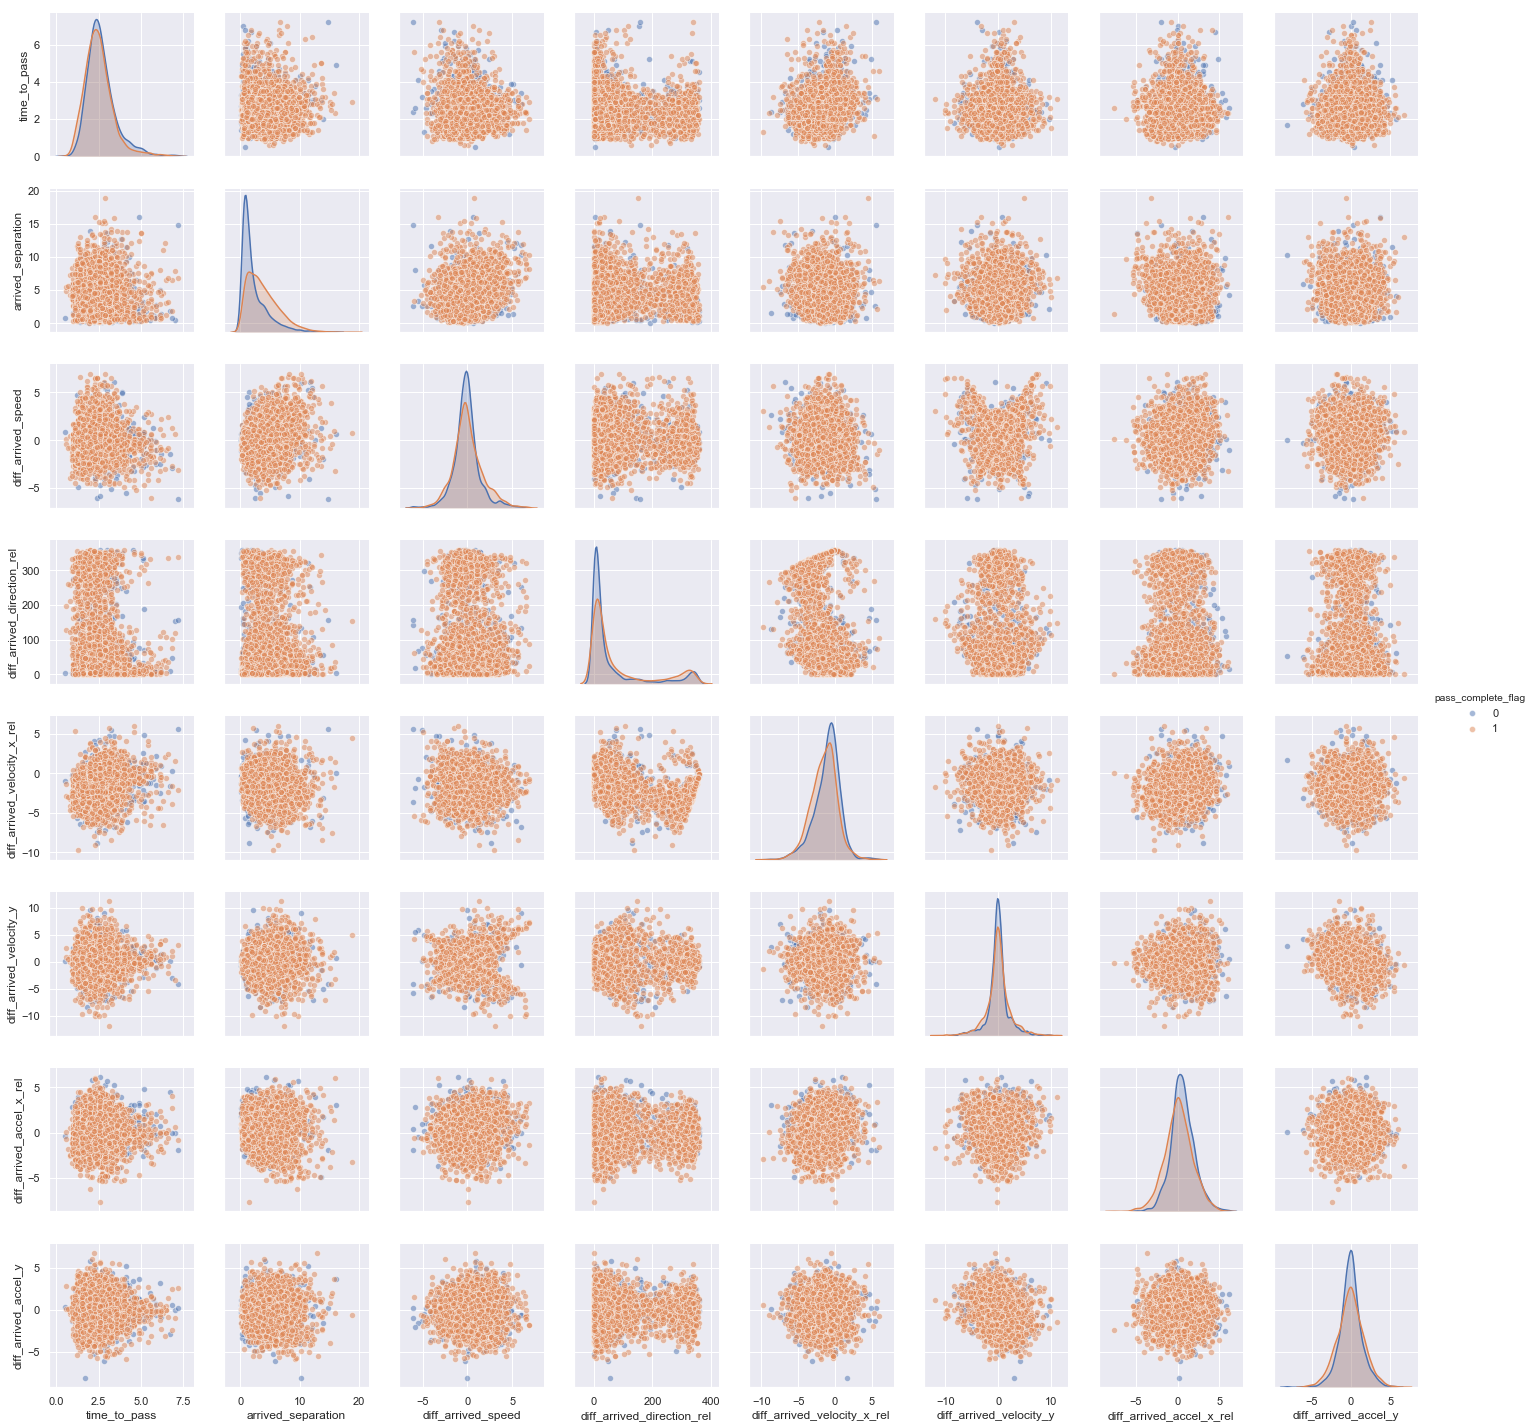

In [45]:
sns.pairplot(data=df_base,
             vars=key_features,
             hue='pass_complete_flag',
             plot_kws={'alpha': 0.5})

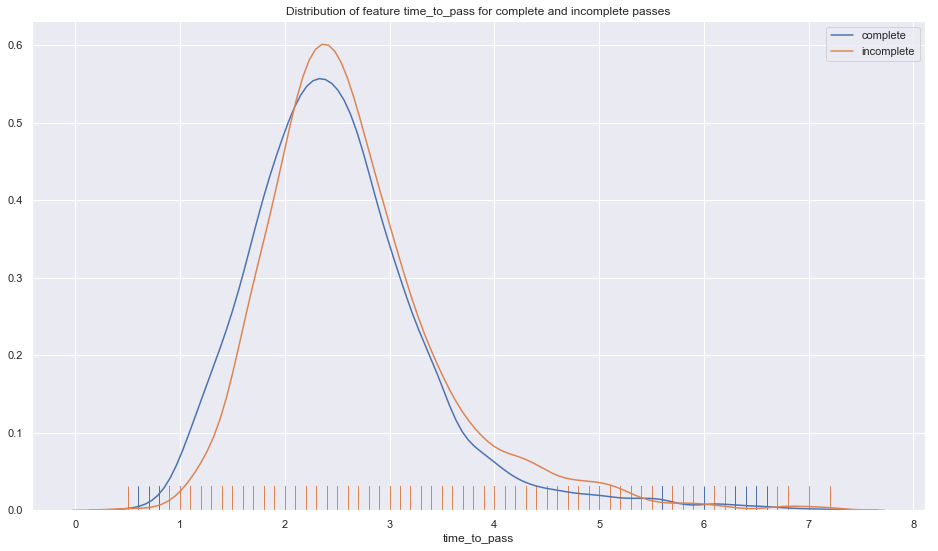

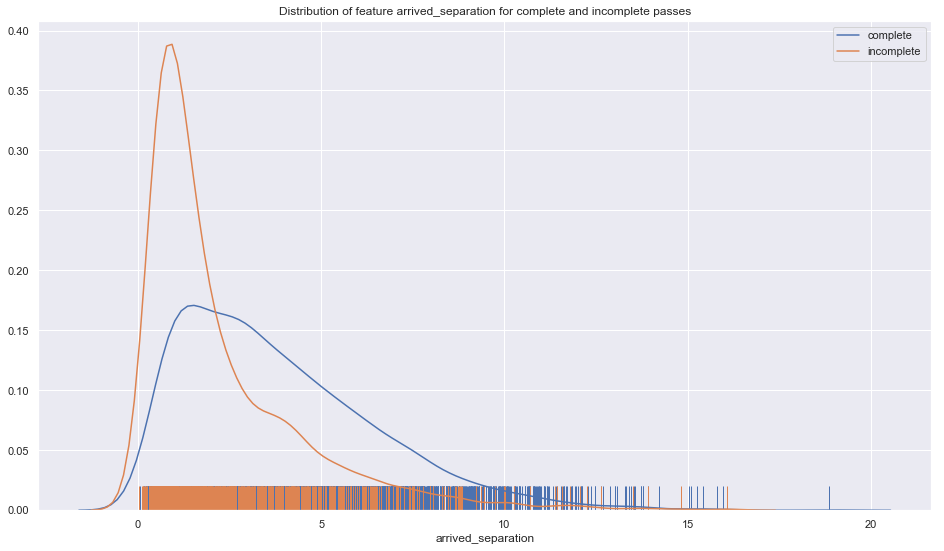

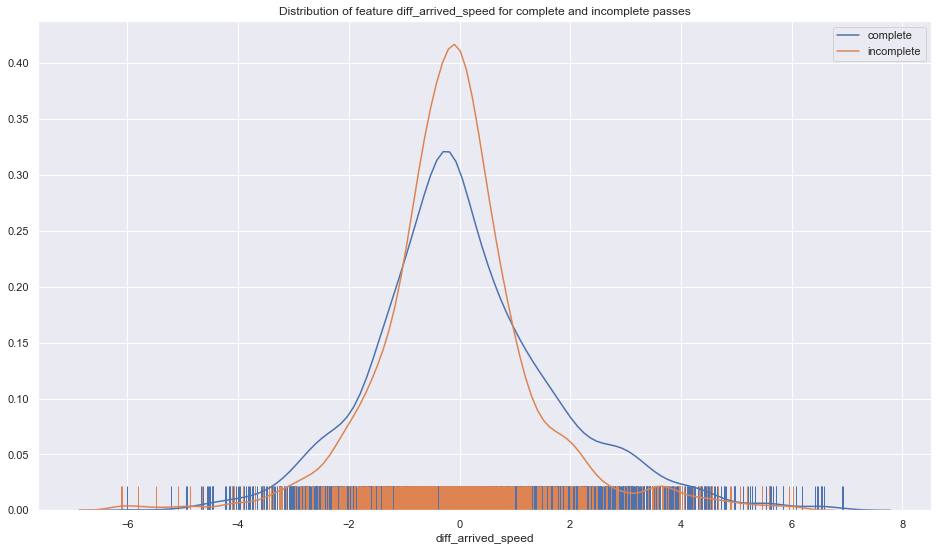

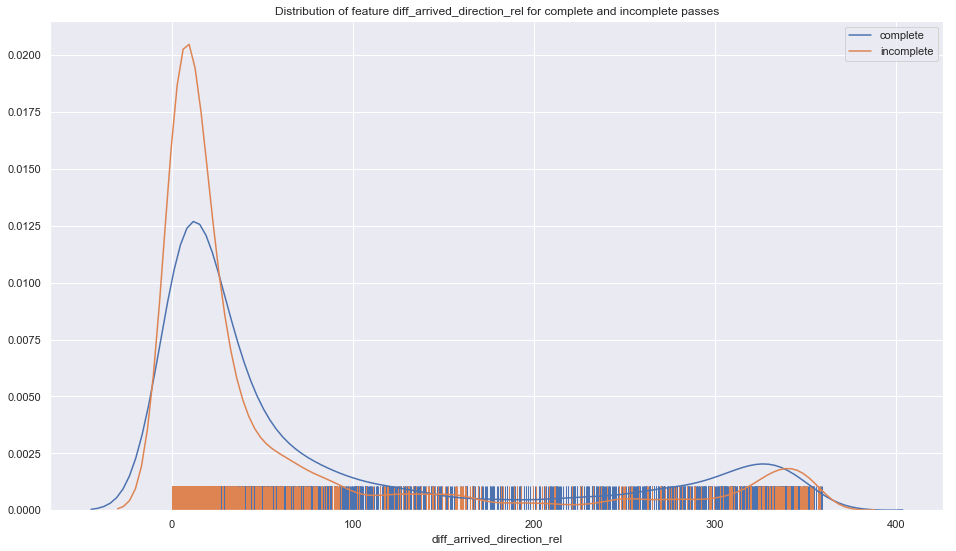

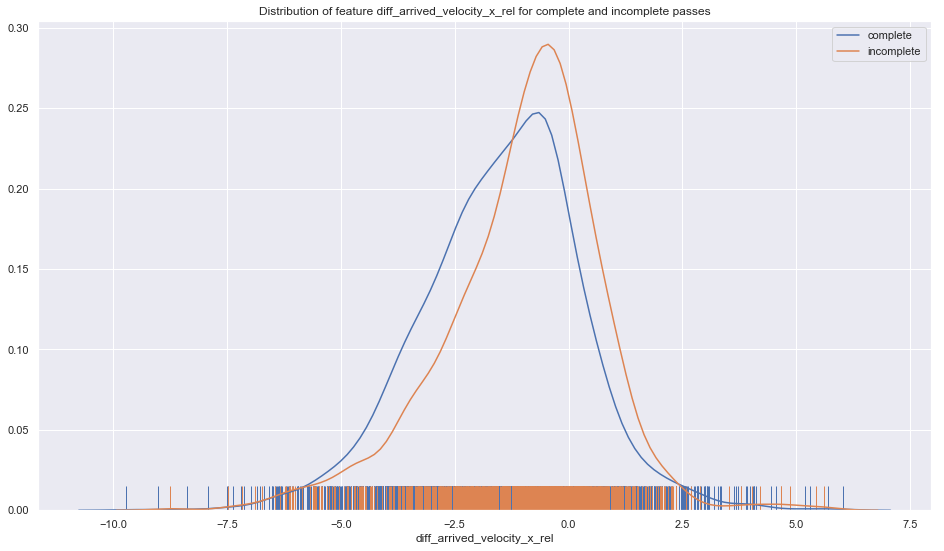

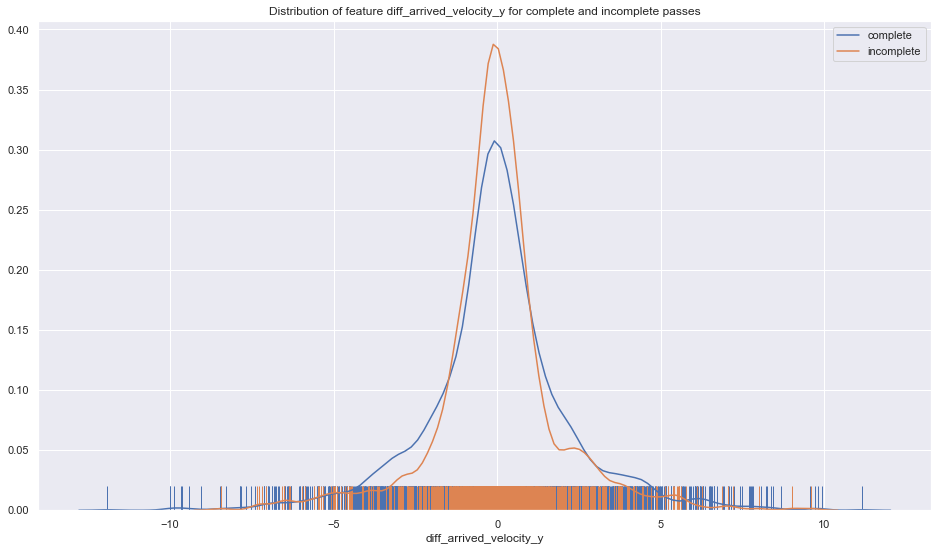

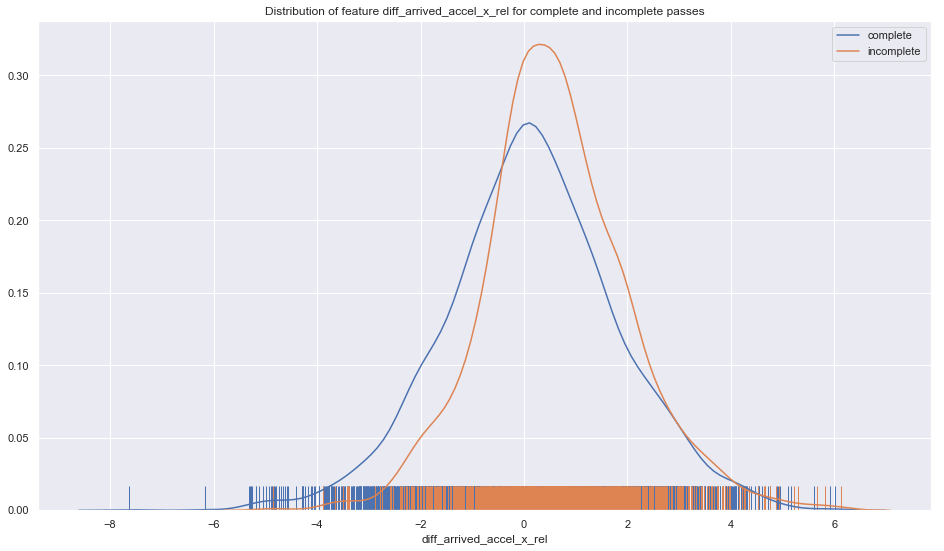

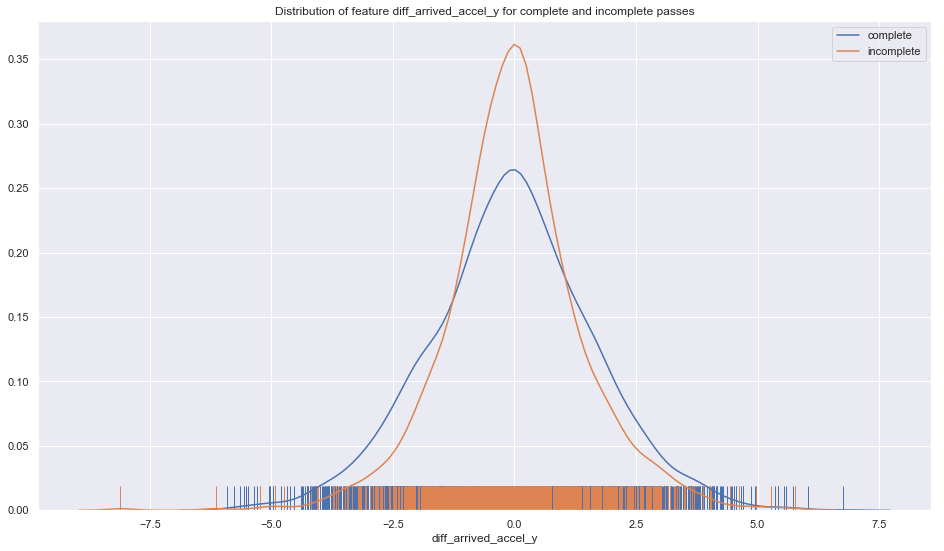

In [46]:
for feature in key_features:
    _comp_data = df_base[_complete][feature]
    _inc_data = df_base[_incomplete][feature]
    
    sns.distplot(a=_comp_data, label='complete', hist=False, rug=True)
    sns.distplot(a=_inc_data, label='incomplete', hist=False, rug=True)

    plt.title('Distribution of feature {:s} for complete and incomplete passes'.format(feature))
    plt.show()

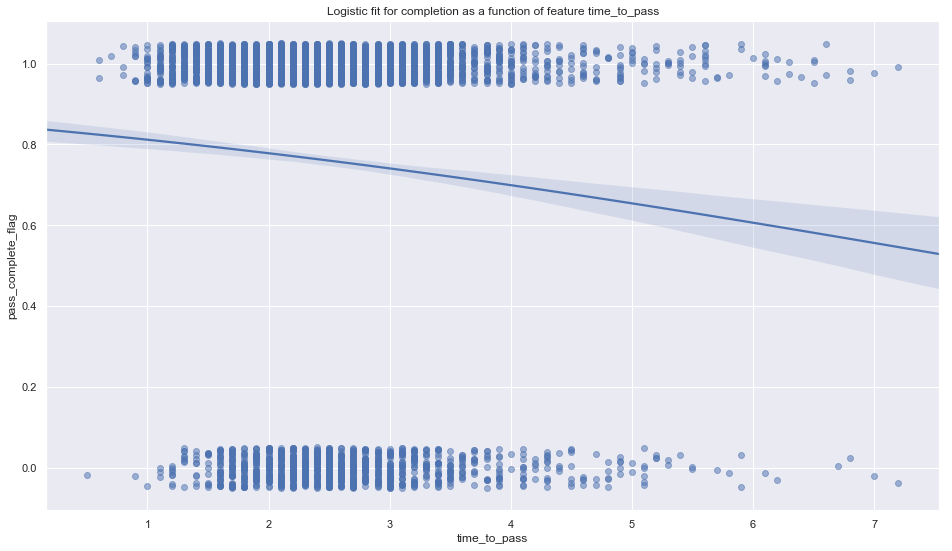

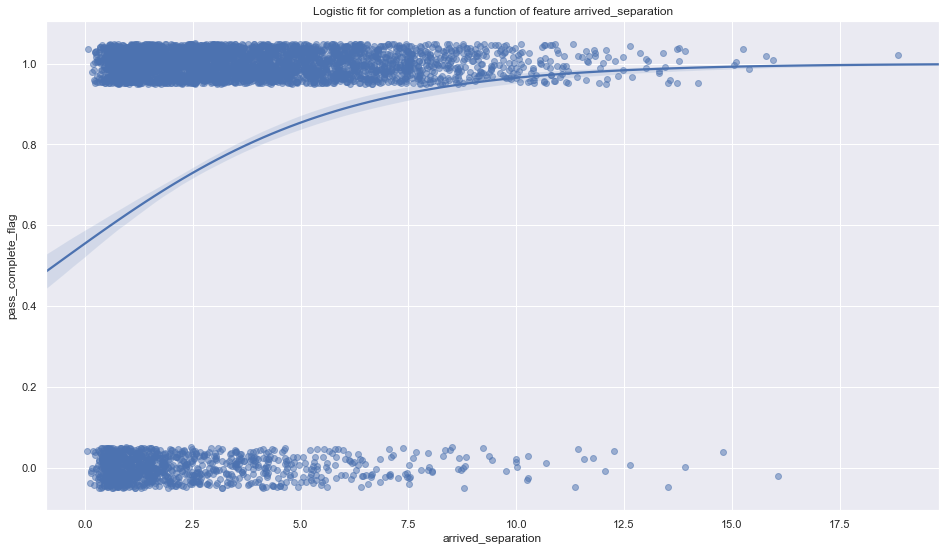

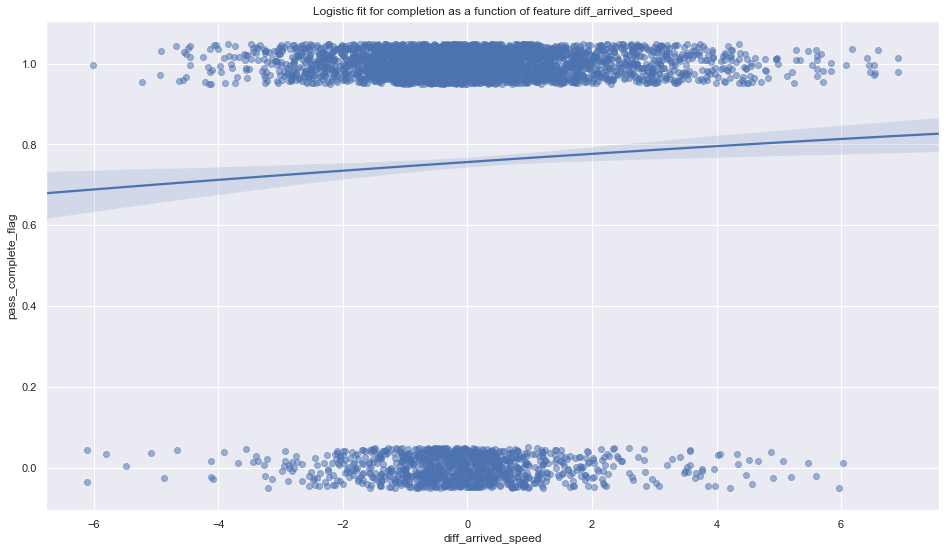

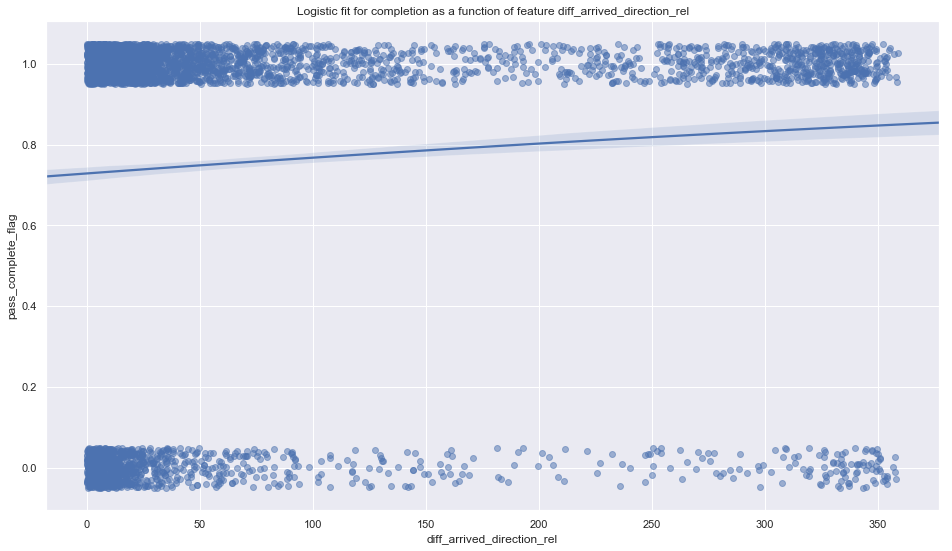

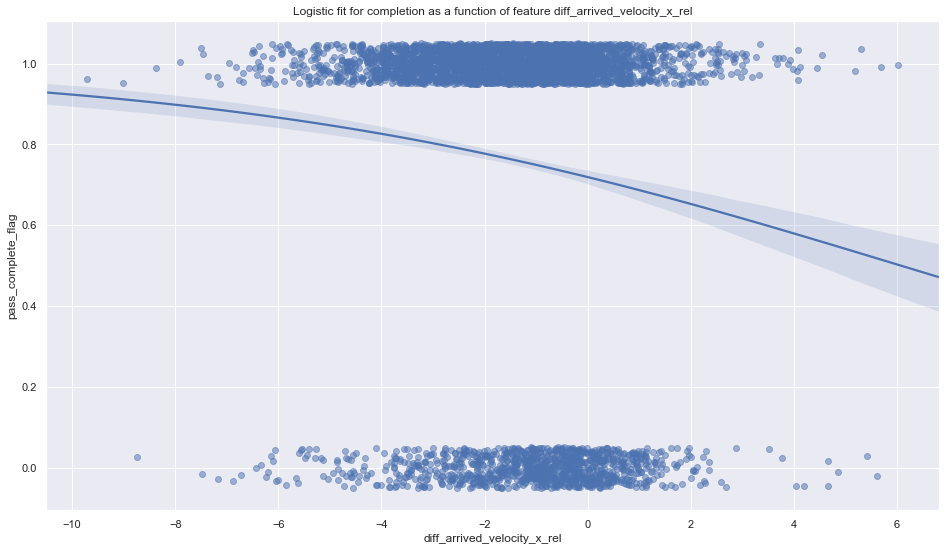

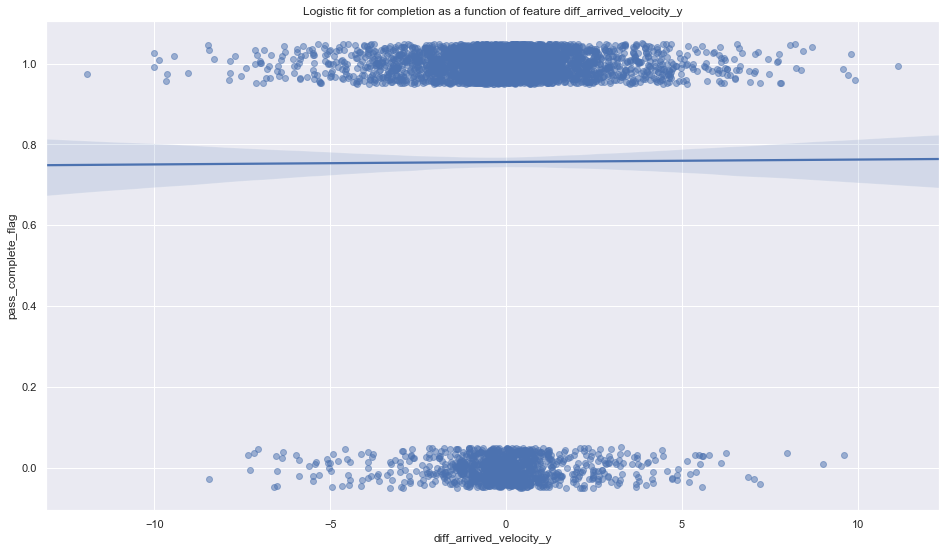

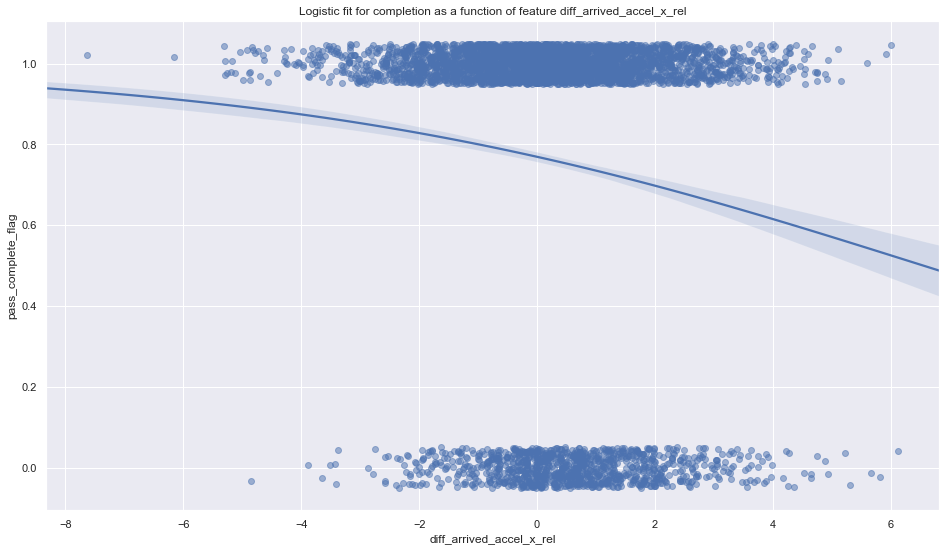

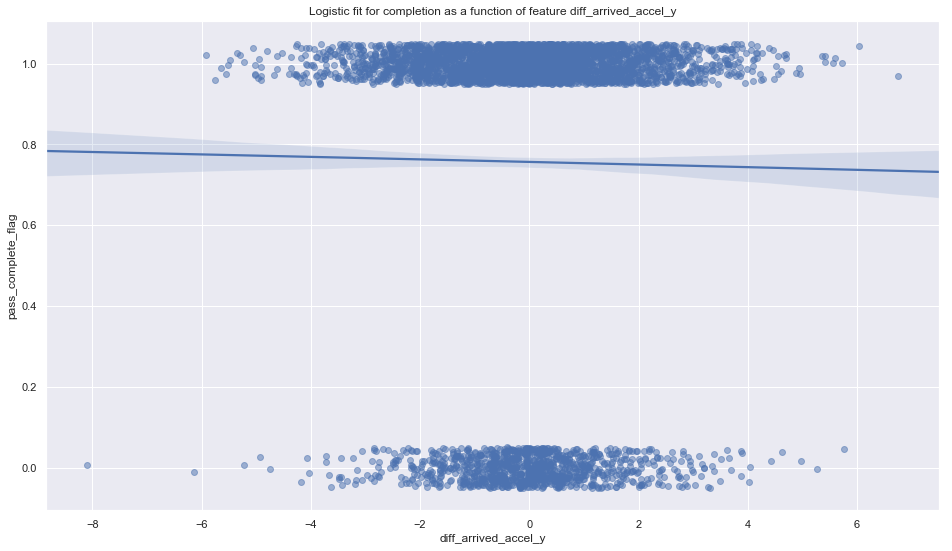

In [47]:
for feature in key_features:    
    sns.regplot(data=df_base,
                x=feature,
                y='pass_complete_flag',
                logistic=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.5})

    plt.title('Logistic fit for completion as a function of feature {:s}'.format(feature))
    plt.show()

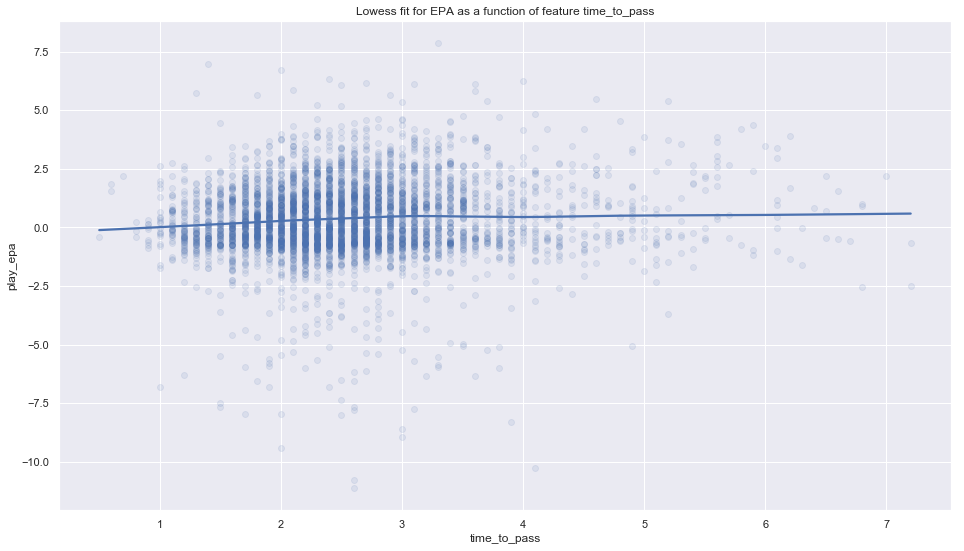

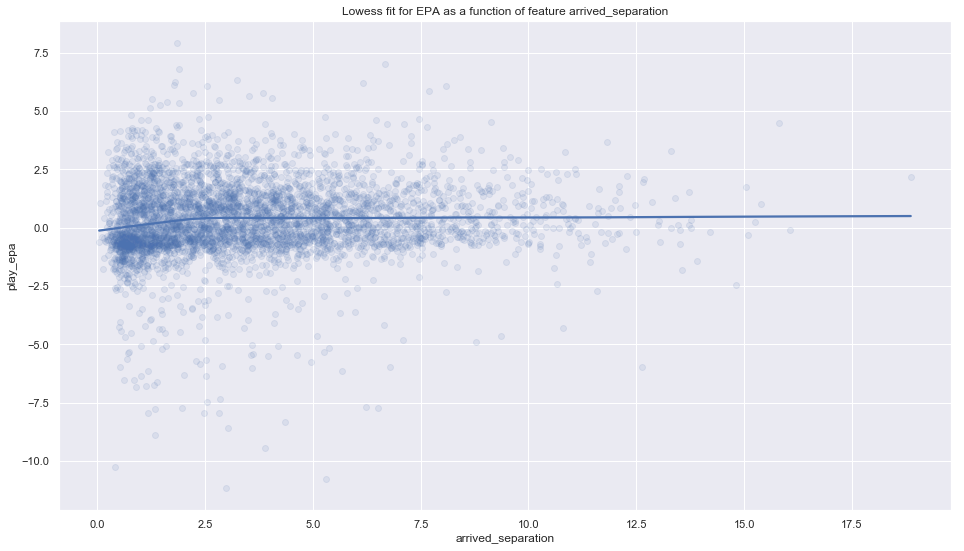

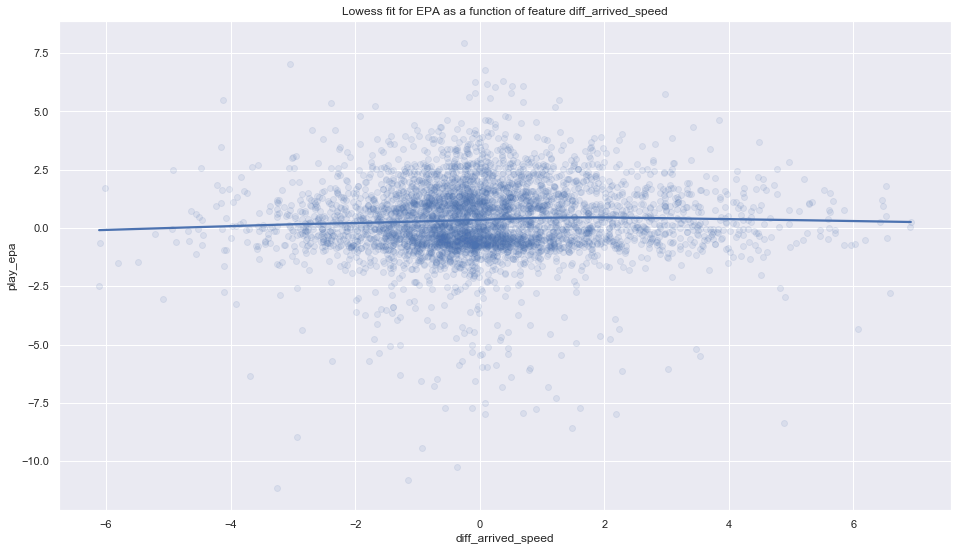

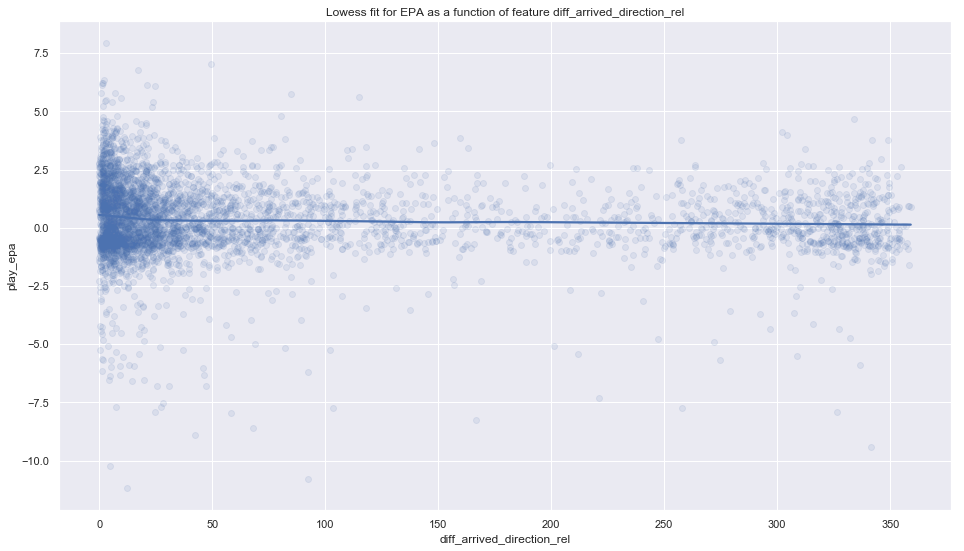

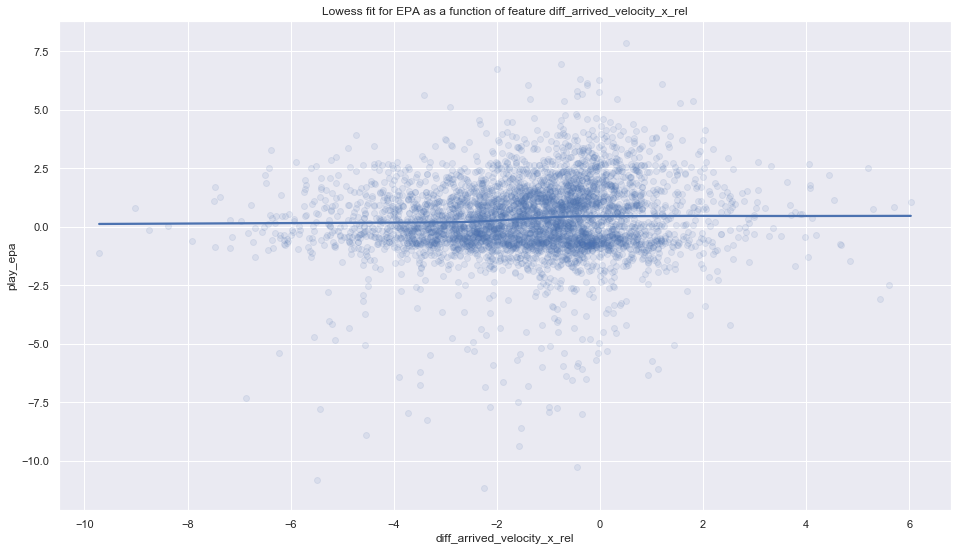

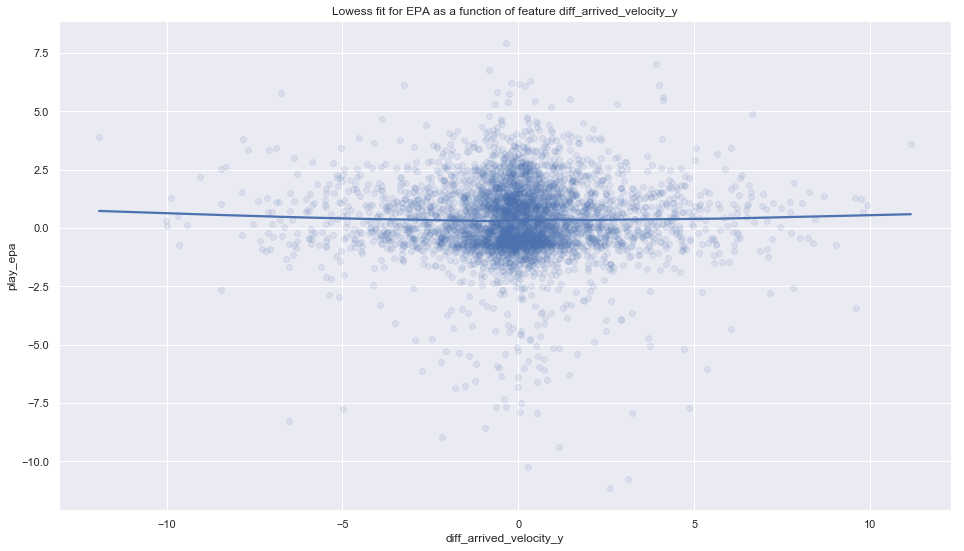

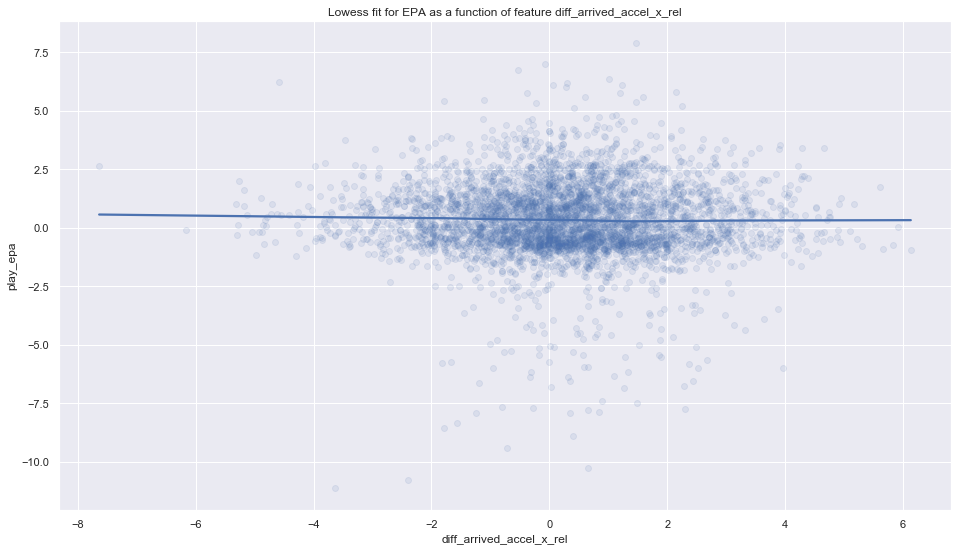

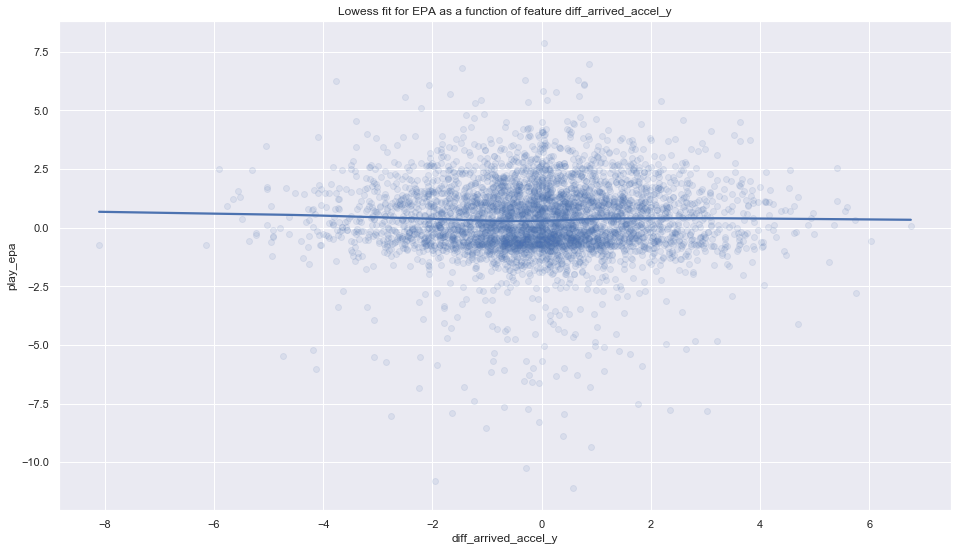

In [50]:
for feature in key_features:    
    sns.regplot(data=df_base,
                x=feature,
                y='play_epa',
                lowess=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.1})

    plt.title('Lowess fit for EPA as a function of feature {:s}'.format(feature))
    plt.show()

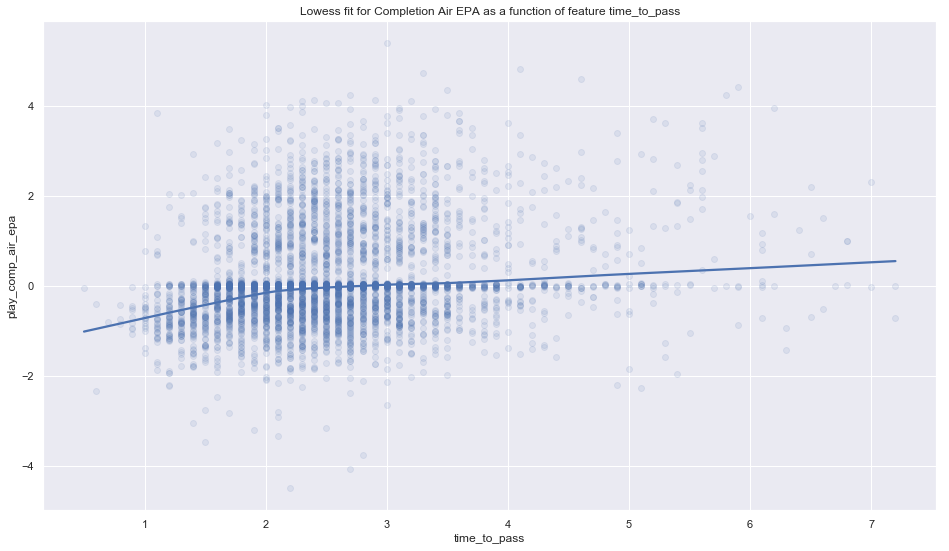

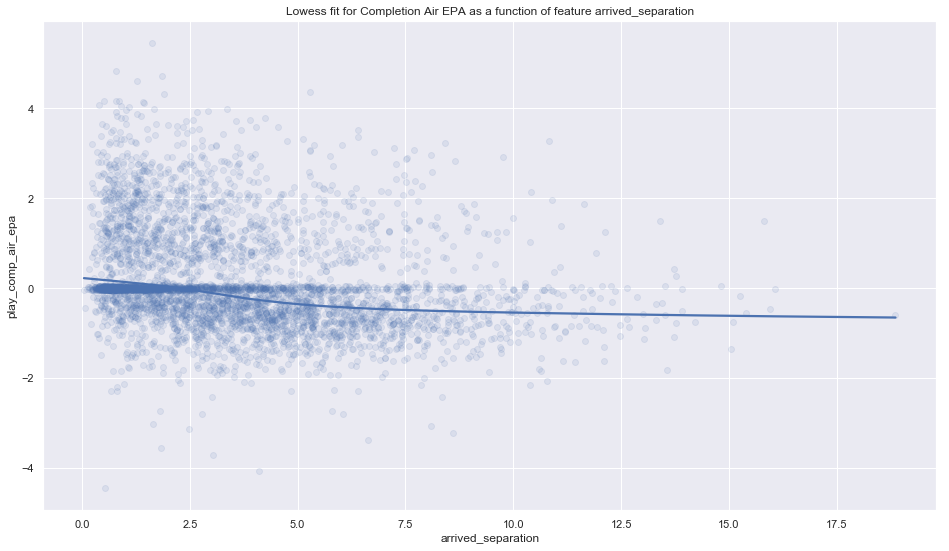

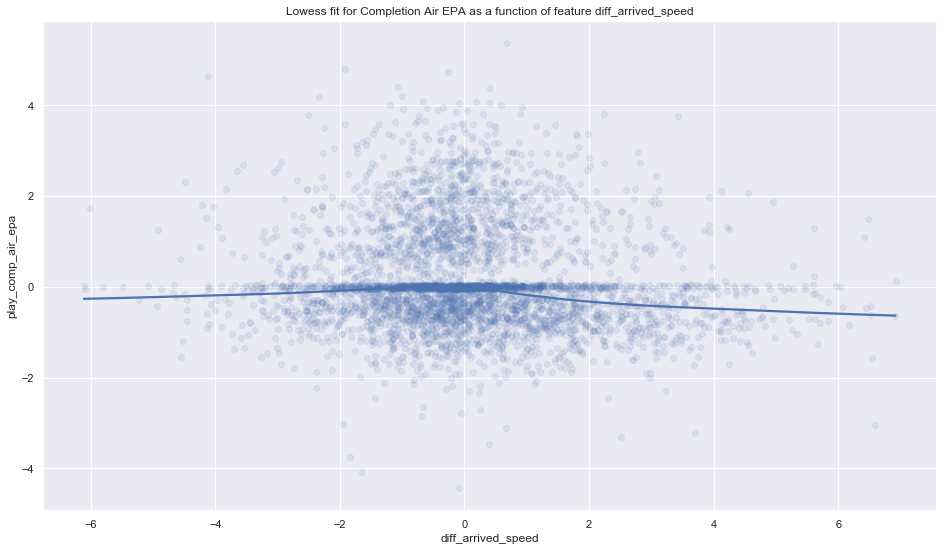

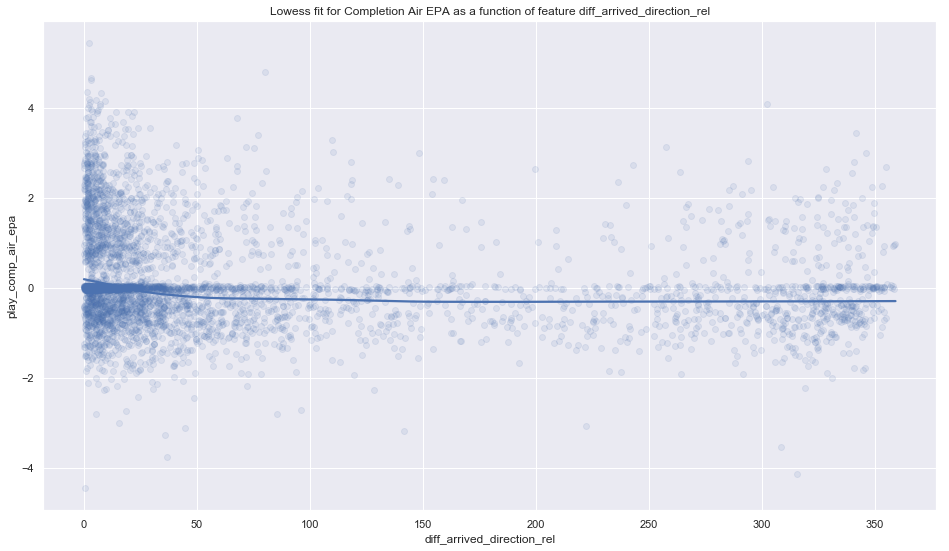

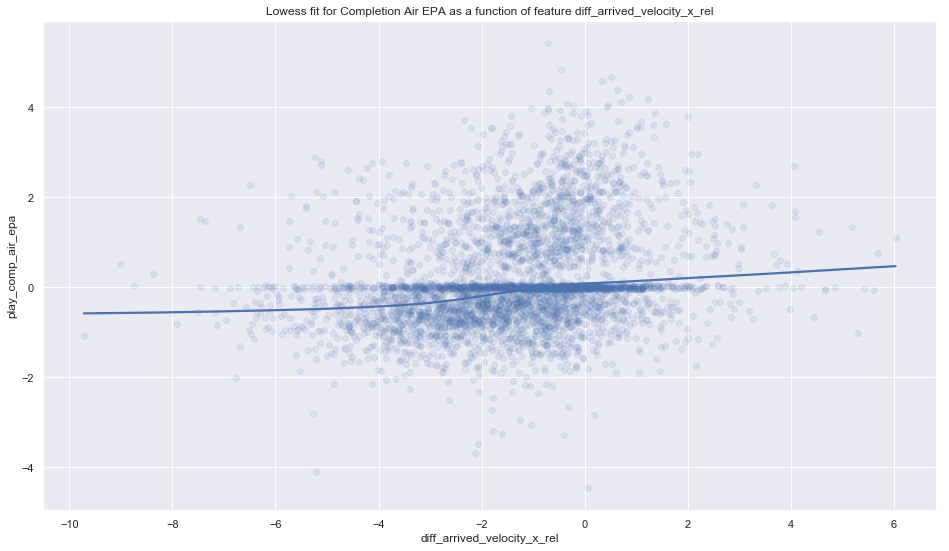

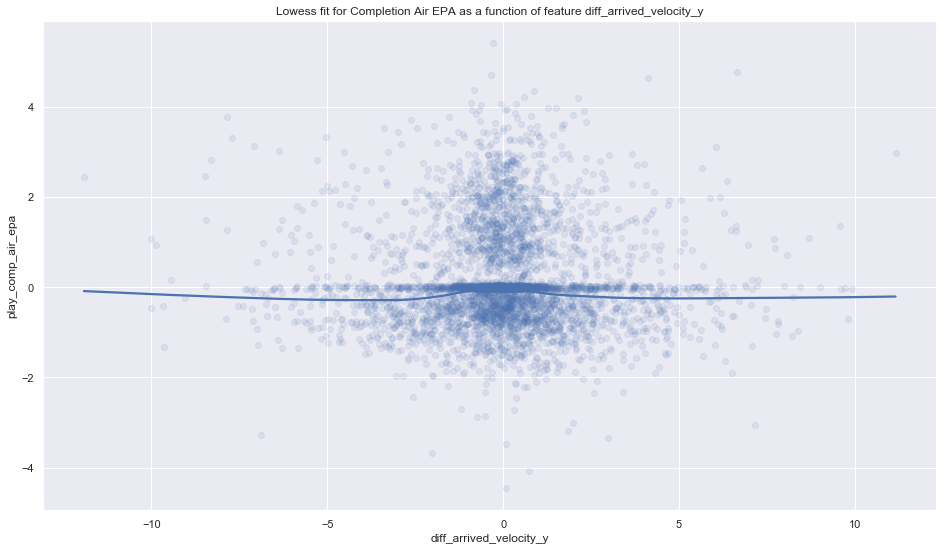

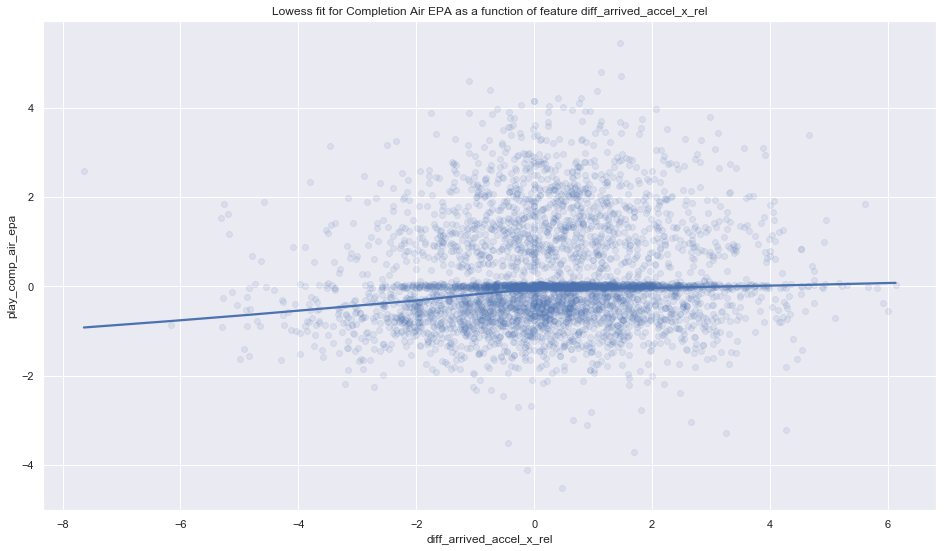

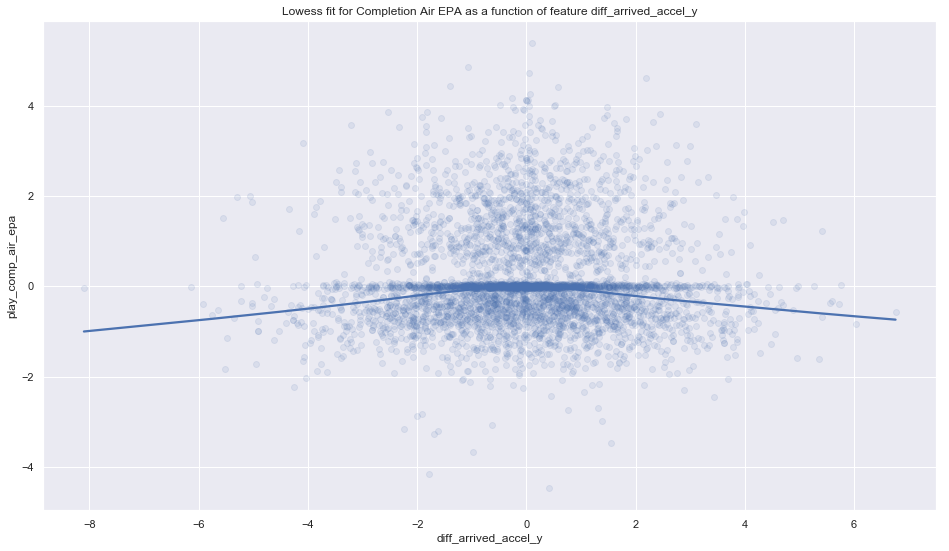

In [51]:
for feature in key_features:    
    sns.regplot(data=df_base,
                x=feature,
                y='play_comp_air_epa',
                lowess=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.1})

    plt.title('Lowess fit for Completion Air EPA as a function of feature {:s}'.format(feature))
    plt.show()

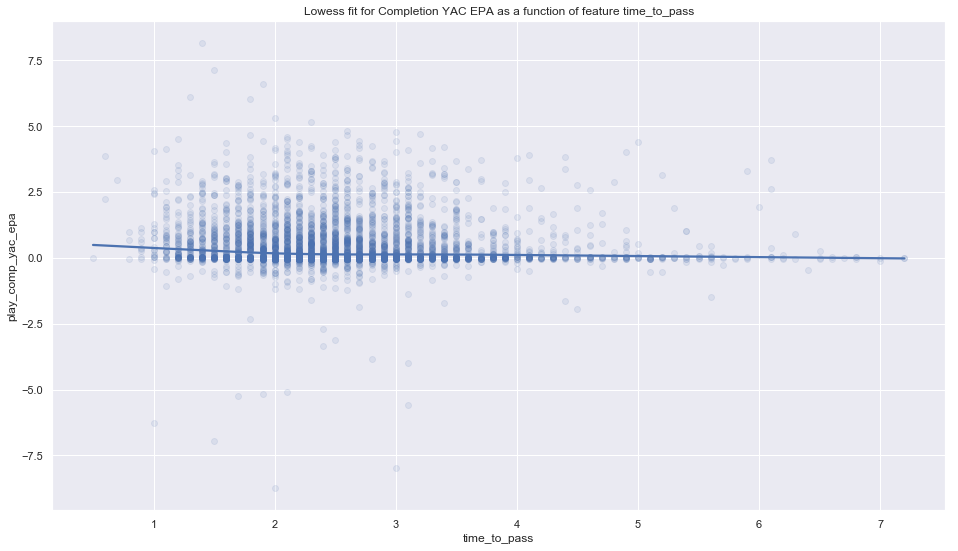

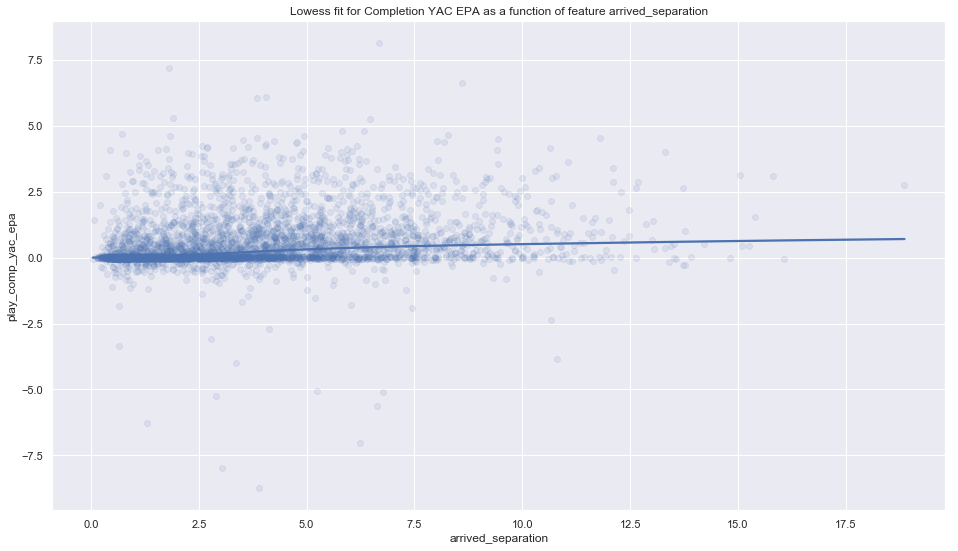

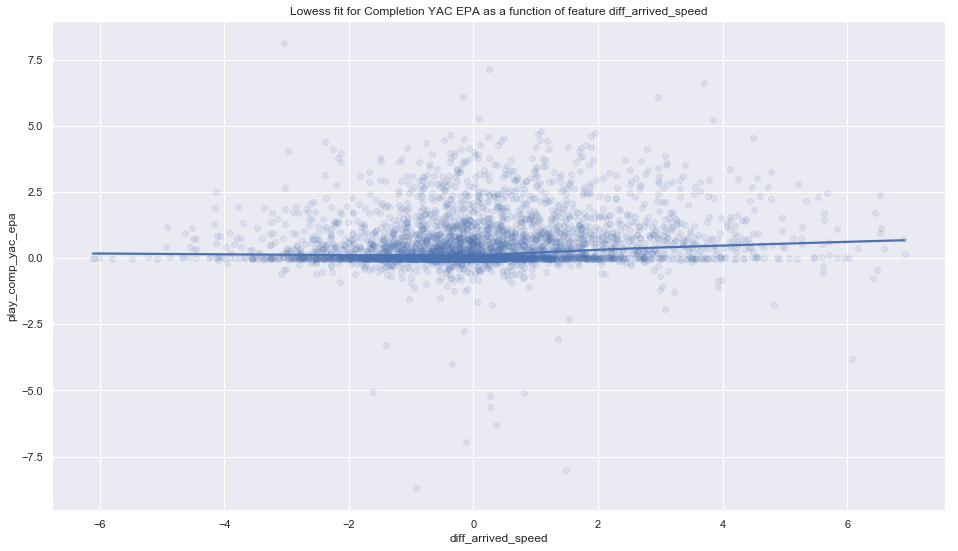

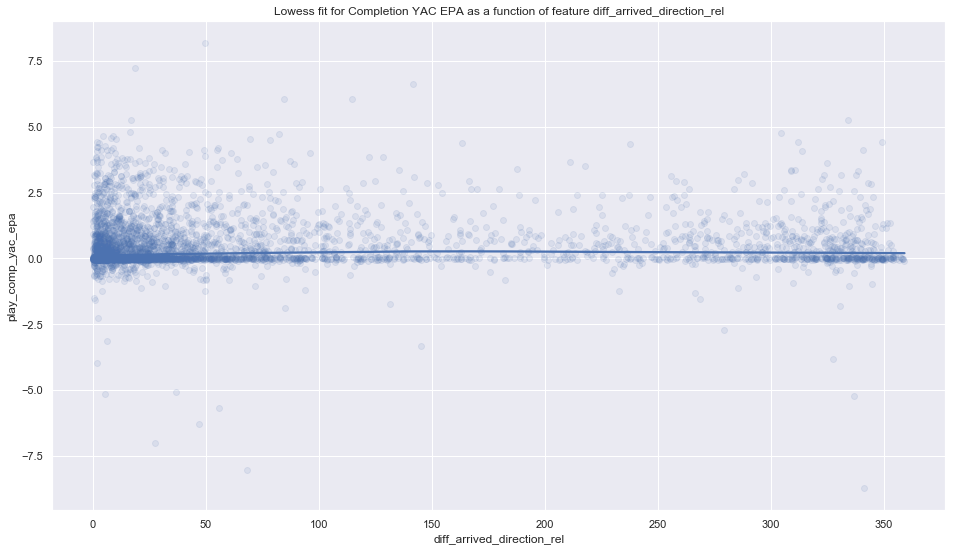

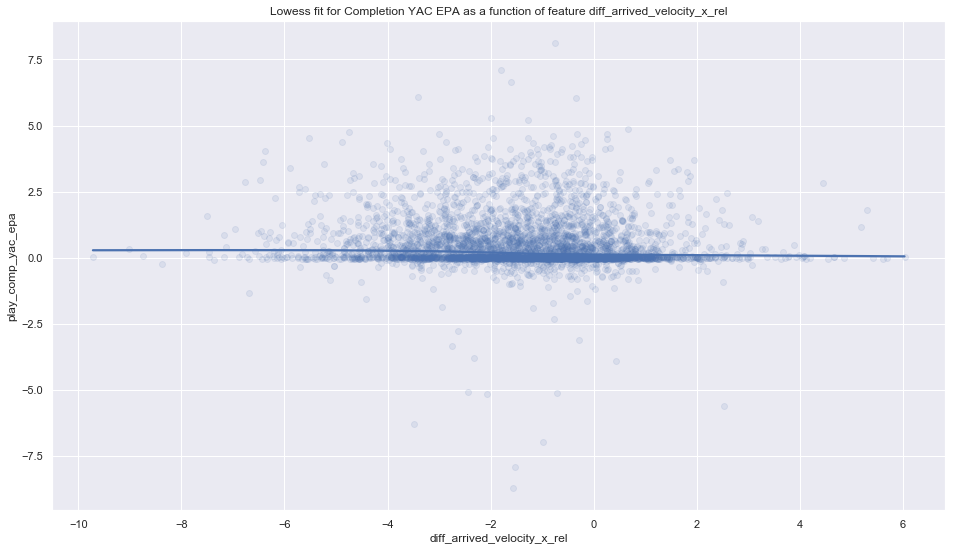

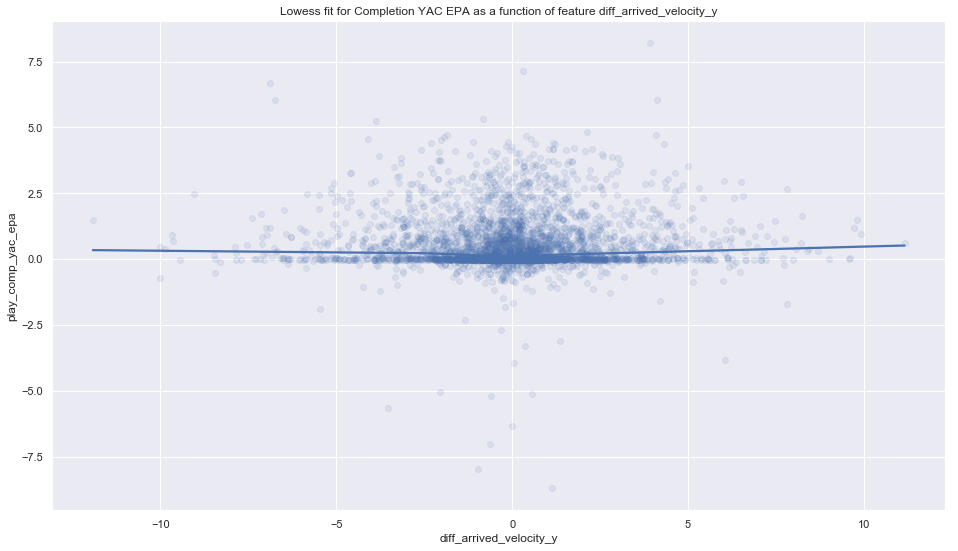

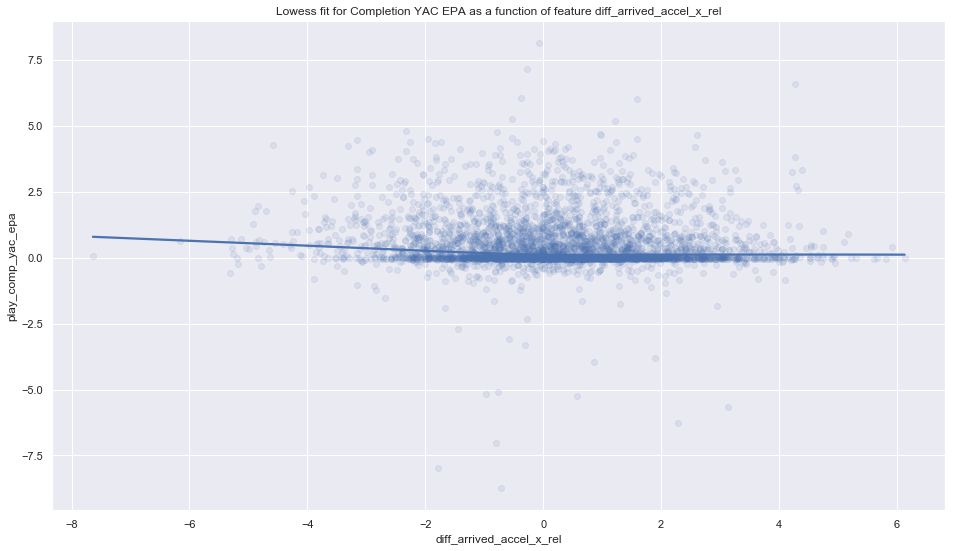

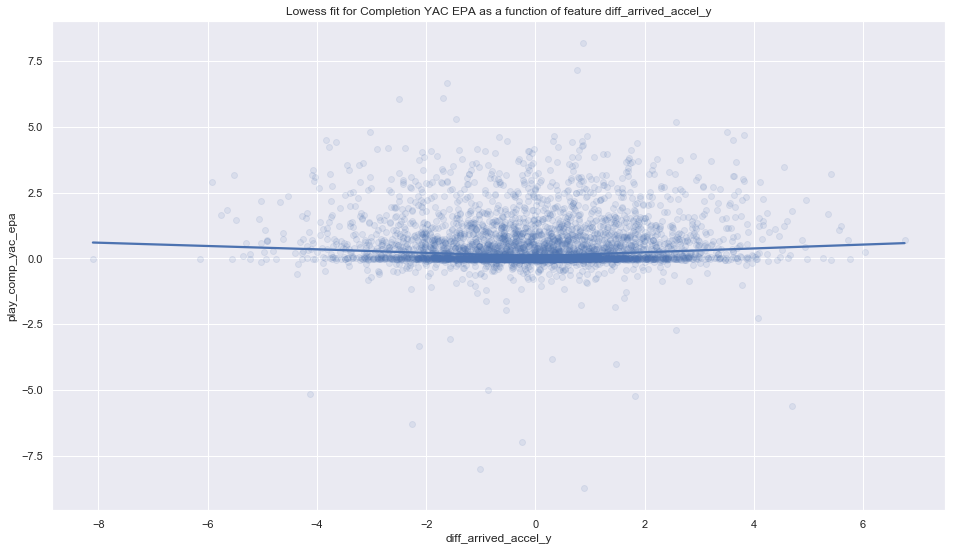

In [53]:
for feature in key_features:    
    sns.regplot(data=df_base,
                x=feature,
                y='play_comp_yac_epa',
                lowess=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.1})

    plt.title('Lowess fit for Completion YAC EPA as a function of feature {:s}'.format(feature))
    plt.show()